In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors



nDivisionsXY = 168
sLength = 84
number_of_events = 1000

def calcEventsMesh(baseDir:str, xhit, yhit):

    mesh = np.zeros((number_of_events, nDivisionsXY, nDivisionsXY))

    for enNum in range(number_of_events):

        # print("Proocessing file #", enNum)

        with open(baseDir+f"/{xhit},{yhit}/evnt_{enNum}_gamma_25GeV_{xhit},{yhit}.txt") as fileEdep:

            fileEdep.readline() # skip 3 firts lines
            fileEdep.readline()
            fileEdep.readline()

            for line in fileEdep:
                lineSplit = line.split(",")

                ix = int(lineSplit[0])
                iy = int(lineSplit[1])

                eDep = float(lineSplit[3])

                mesh[enNum, ix, iy] += eDep

    return mesh


In [2]:
# mesh = calcEventsMesh("build/eDepMaps", 3,3)



# mesh = np.mean(mesh, axis=0)

# eDepMean = np.sum(mesh)



# #################################
# ## eDep plots
# #################################
# plt.figure(figsize=(3*6.4, 3*4.8))
# plt.imshow(np.transpose(mesh)[::-1,:], extent=(-sLength, sLength, -sLength, sLength), norm=colors.LogNorm(vmin=1e-3))
# cbar = plt.colorbar()
# cbar.ax.set_ylabel("Deposited Energy [MeV]")
# plt.xlabel("x [mm]")
# plt.ylabel("y [mm]")
# ax = plt.gca()
# ax.text(0.55, 0.01, "dx = dy = {:.2f} mm".format(sLength*2/nDivisionsXY), transform=ax.transAxes, color="orange")
# ax.text(0.05, 0.01, "Mean (over events)\ndeposited energy\nis {:.2f} MeV".format(eDepMean),
#                 transform=ax.transAxes, color="orange")

In [3]:
meshs_dict = {}

for i in range(4):
    for j in range(0,i+1):

        key = f"X={i},Y={j}"

        print(key)

        meshs_dict[key] = calcEventsMesh("build/eDepMaps", i,j)



X=0,Y=0
X=1,Y=0
X=1,Y=1
X=2,Y=0
X=2,Y=1
X=2,Y=2
X=3,Y=0
X=3,Y=1
X=3,Y=2
X=3,Y=3


In [4]:
meshs_dict_no_fib = meshs_dict



for key, item in meshs_dict_no_fib.items():

    idxs = np.arange(3,168, 7)

    idxs_x, idxs_y = np.meshgrid(idxs, idxs)

    idxs_x = idxs_x.flatten()
    idxs_y = idxs_y.flatten()

    item[:,idxs_x,idxs_y] = 0

Text(0.05, 0.01, 'Mean (over events)\ndeposited energy\nis 968.31 MeV')

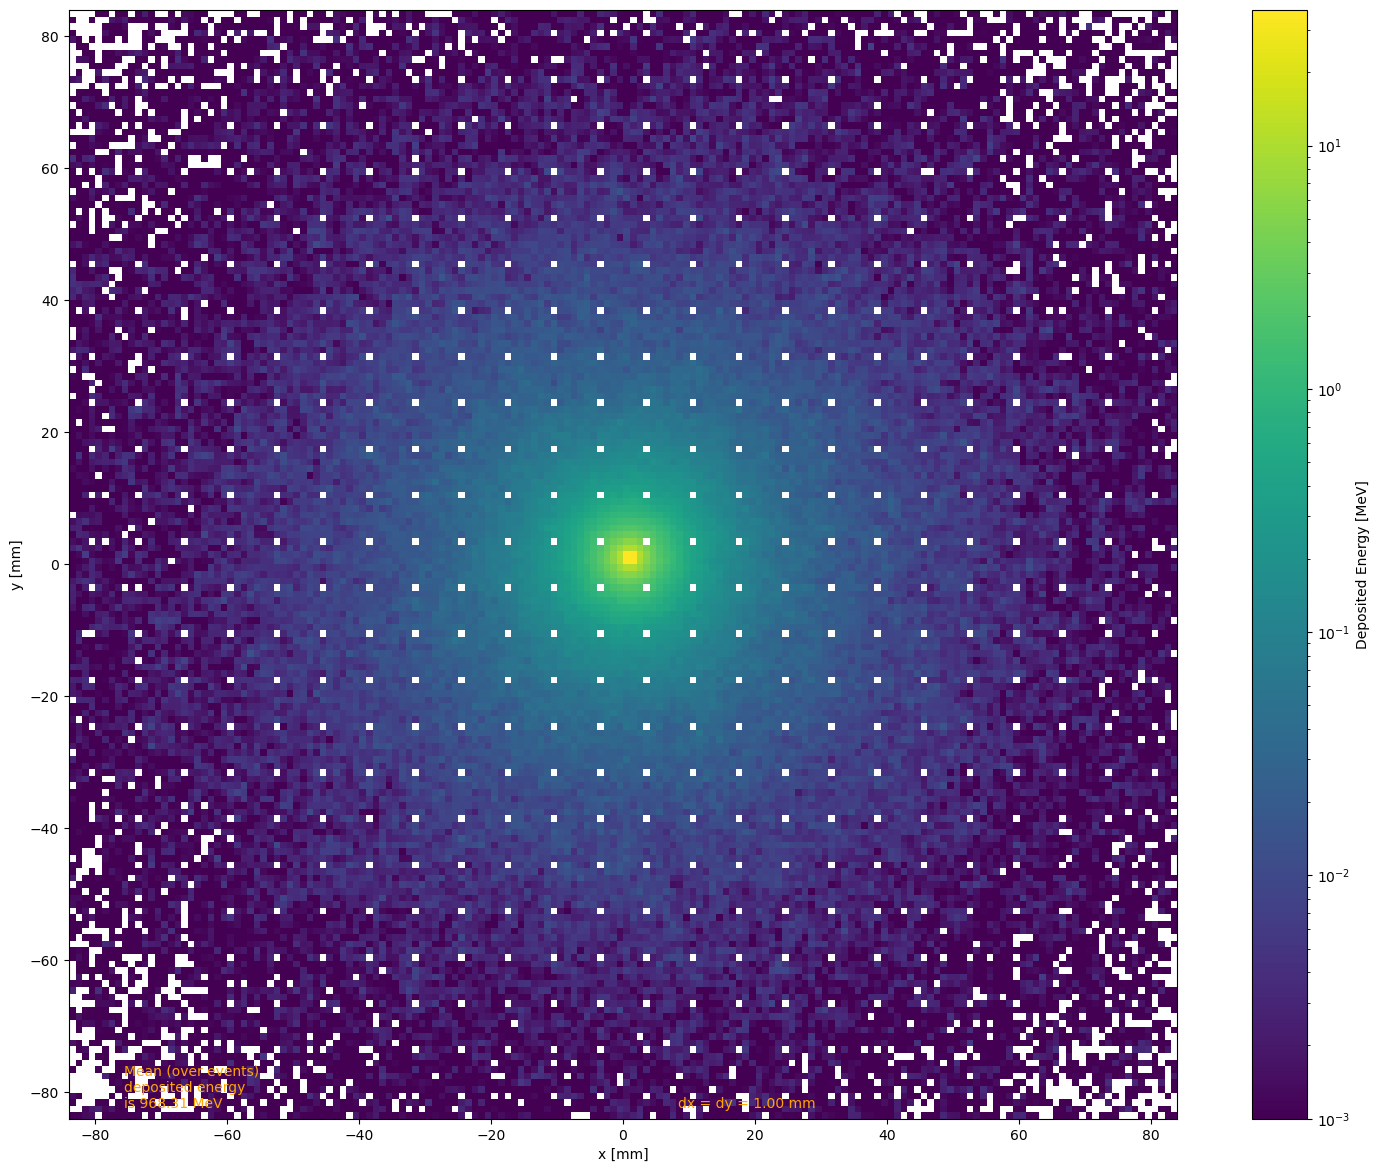

In [5]:
mesh = meshs_dict_no_fib["X=1,Y=1"]

mesh = np.mean(mesh, axis=0)

eDepMean = np.sum(mesh)

#################################
## eDep plots
#################################
plt.figure(figsize=(3*6.4, 3*4.8))
plt.imshow(np.transpose(mesh)[::-1,:], extent=(-sLength, sLength, -sLength, sLength), norm=colors.LogNorm(vmin=1e-3))
cbar = plt.colorbar()
cbar.ax.set_ylabel("Deposited Energy [MeV]")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
ax = plt.gca()
ax.text(0.55, 0.01, "dx = dy = {:.2f} mm".format(sLength*2/nDivisionsXY), transform=ax.transAxes, color="orange")
ax.text(0.05, 0.01, "Mean (over events)\ndeposited energy\nis {:.2f} MeV".format(eDepMean),
                transform=ax.transAxes, color="orange")

Text(0, 0.5, 'y [mm]')

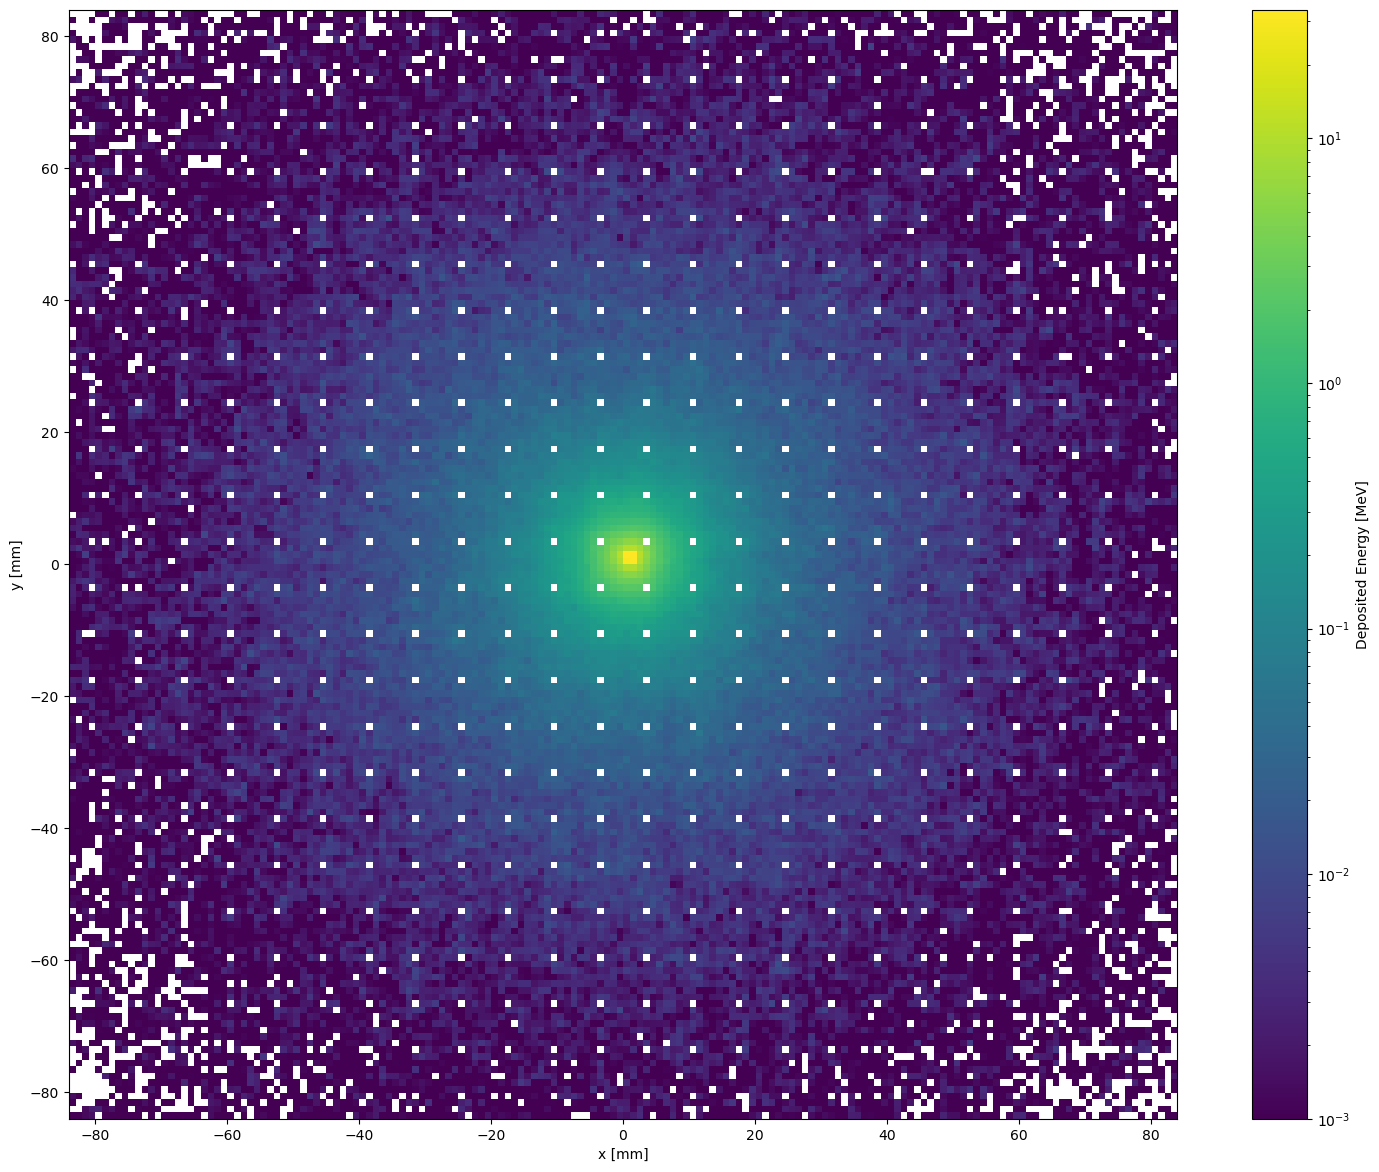

In [6]:
x = np.linspace(-sLength+0.5, sLength-0.5, nDivisionsXY)

X, Y = np.meshgrid(x, x)

modulated = mesh*(1-0.07*np.cos(2*np.pi * X / 7) - 0.07*np.cos(2*np.pi * Y / 7))

plt.figure(figsize=(3*6.4, 3*4.8))
plt.imshow(np.transpose(modulated)[::-1,:], extent=(-sLength, sLength, -sLength, sLength), norm=colors.LogNorm(vmin=1e-3))
cbar = plt.colorbar()
cbar.ax.set_ylabel("Deposited Energy [MeV]")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")

In [7]:
from scipy.optimize import curve_fit 

def dispHistAndGauss(ax, data):

    # n_bins = int(np.sqrt(data.size))
    n_bins = 50
    bin_size = (np.max(data) - np.min(data))/n_bins

    histCounts, edges, _ = ax.hist(data, bins = n_bins)
    binCenters = (edges[1:] + edges[:-1])/2

    gaussFunc = lambda x, A, mu, sig: A*np.exp(-(x-mu)**2/sig**2/2)
    mu = np.mean(data)
    sig = np.std(data, ddof=1)
    A = data.size/(np.sqrt(2*np.pi)*sig)*bin_size
    p0 = (A, mu, sig)

    (A, mu, sig), _ = curve_fit(gaussFunc, binCenters, histCounts , p0=p0)

    x_gauss = np.linspace(np.min(data), np.max(data), 4*n_bins)
    y_gauss = gaussFunc(x_gauss, A, mu, sig)

    ax.plot(x_gauss, y_gauss, "r", label="$\sigma={:.2e}$\n$\mu={:.2e}$".format(sig, mu))
    ax.set_xlabel("$(\\tilde{E}_{ecs} - E_{ecs})/E_0$")
    ax.legend()

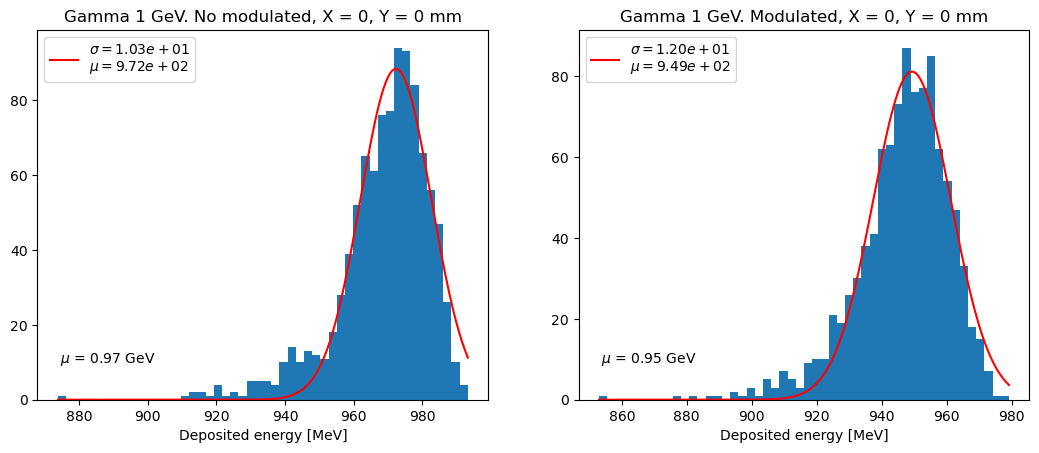

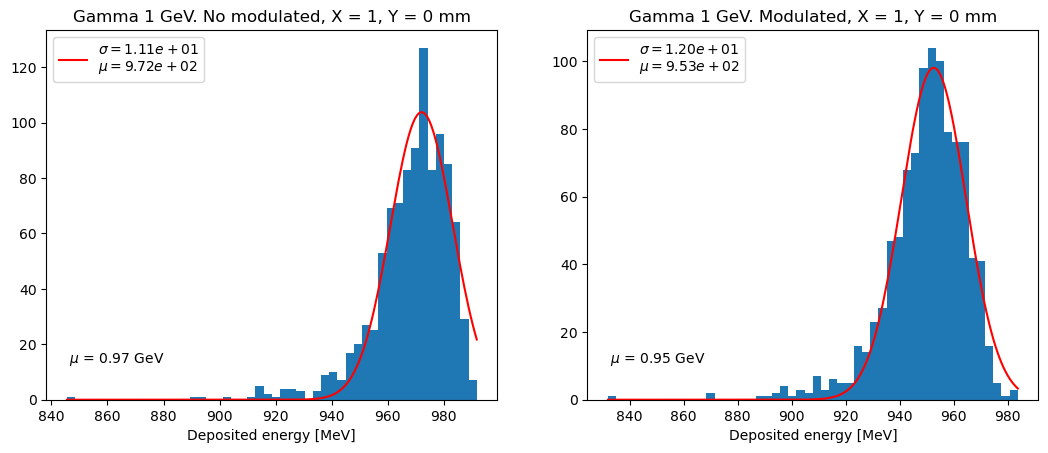

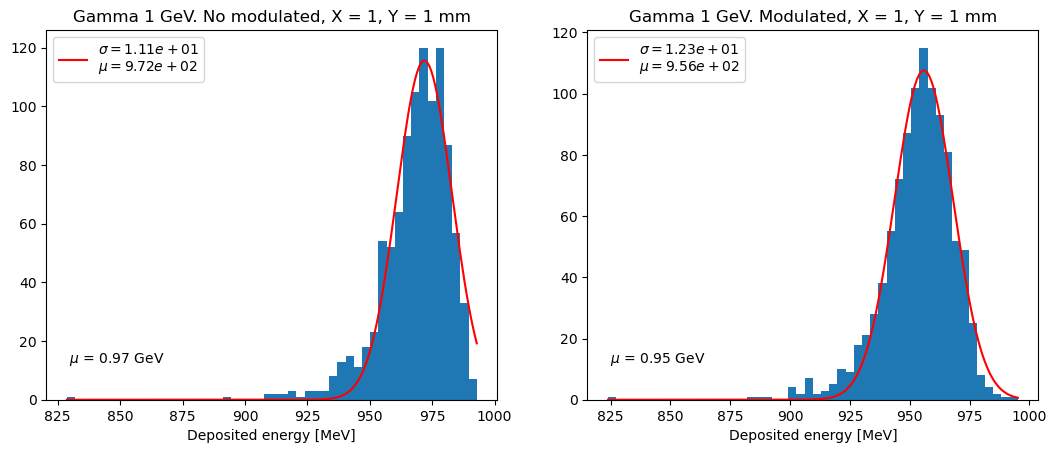

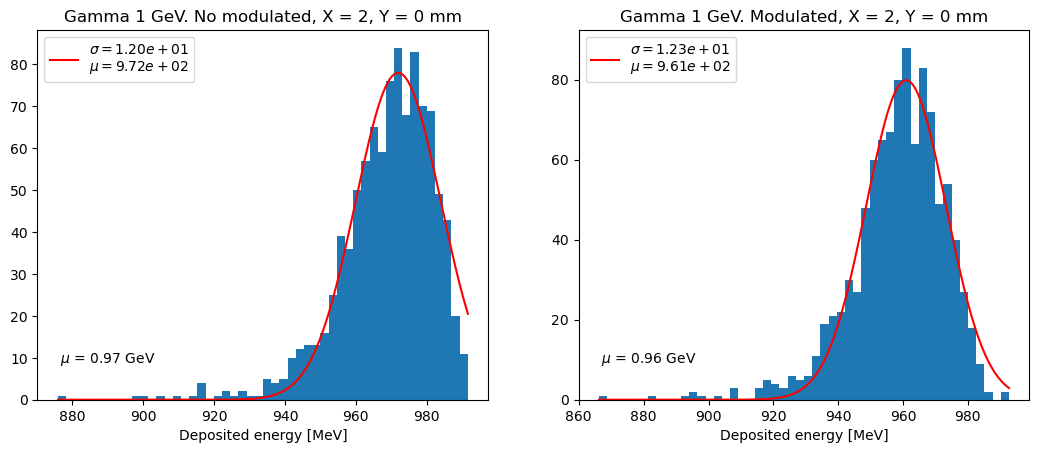

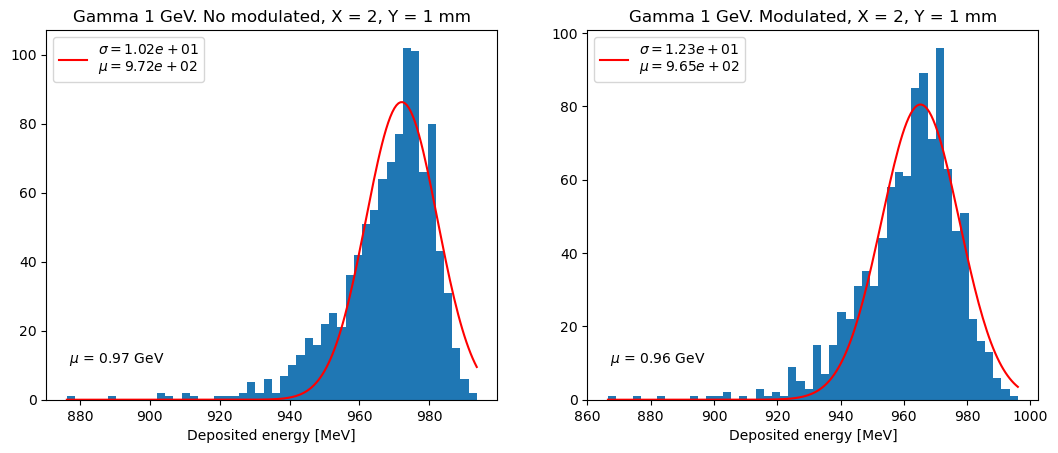

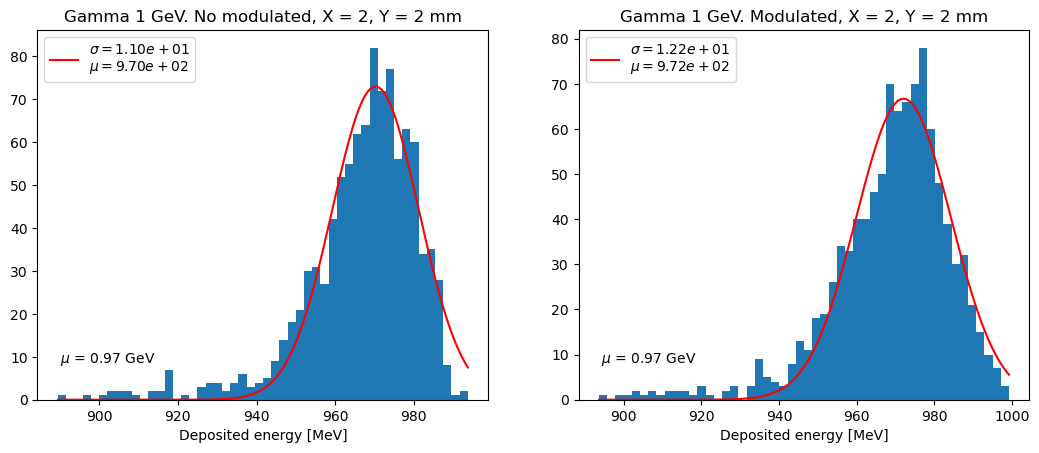

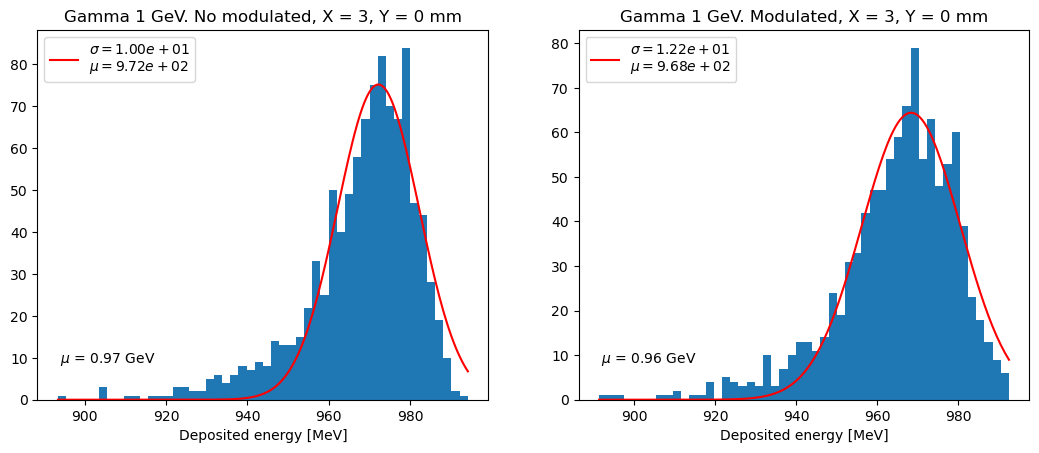

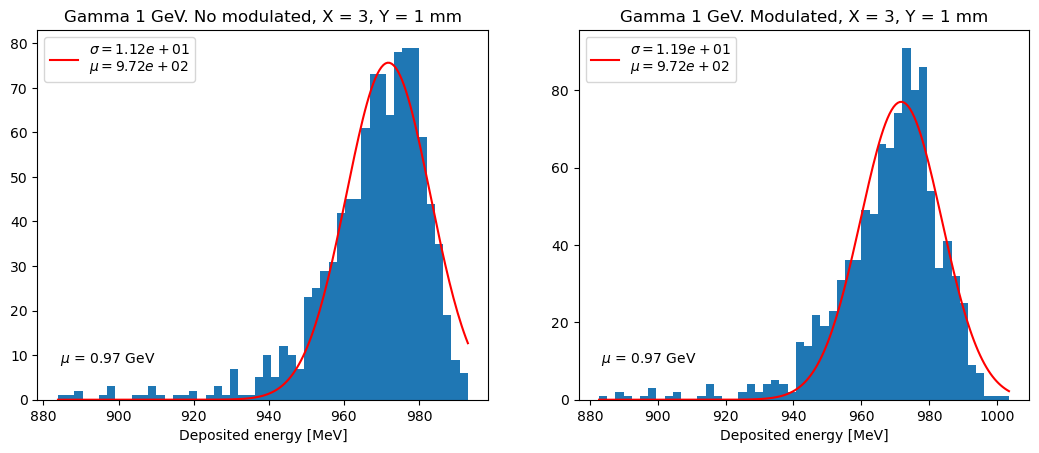

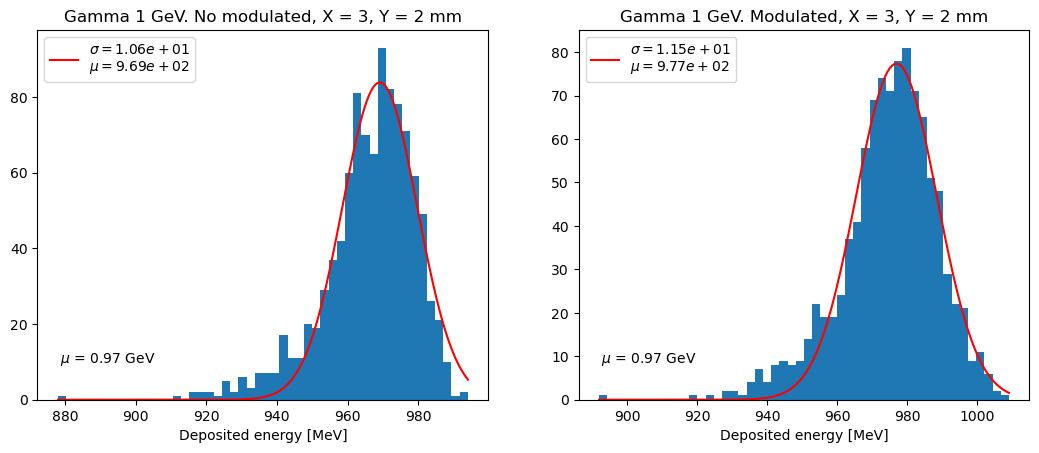

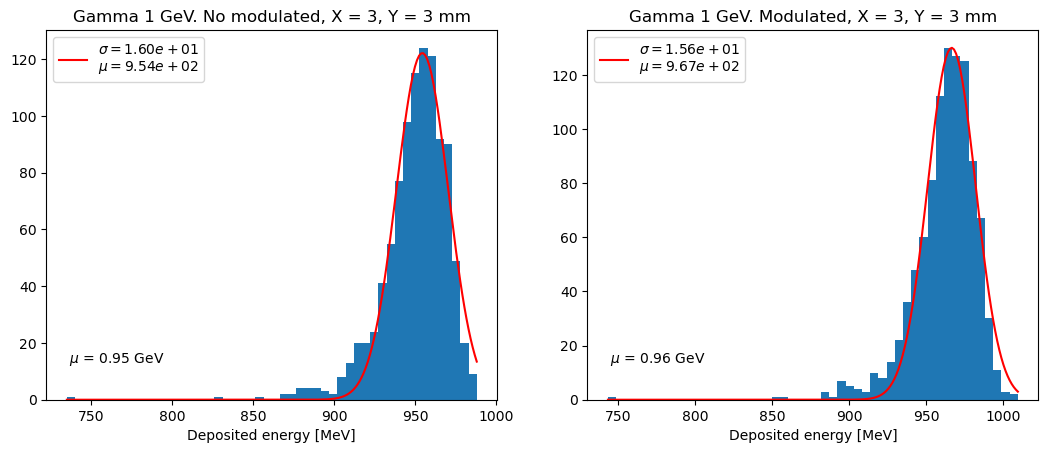

In [8]:
meanDetectedEdeps = {}
eDeps_modulated_dict = {}

for i in range(4):
    for j in range(0,i+1):

        key = f"X={i},Y={j}"

        eDeps = meshs_dict_no_fib[key]

        eDeps = np.sum(eDeps, axis=-1)
        eDeps = np.sum(eDeps, axis=-1)

        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(2*6.4, 1*4.8))
        # ax1.hist(eDeps[eDeps > 22500], bins=40, label="$\mu = {:.4f}$ GeV".format( np.mean(eDeps)/1000 ))
        dispHistAndGauss(ax1, eDeps)

        ax1.text(0.05, 0.1, "$\mu$ = {:.2f} GeV".format(np.mean(eDeps)/1000), transform=ax1.transAxes)

        ax1.set_title(f"Gamma 1 GeV. No modulated, X = {i}, Y = {j} mm")
        ax1.set_xlabel("Deposited energy [MeV]")
        ax1.legend()

        ####################################################################

        eDeps = meshs_dict_no_fib[key]

        x = np.linspace(-sLength+0.5, sLength-0.5, nDivisionsXY)

        X, Y = np.meshgrid(x, x)

        X = np.expand_dims(X, axis = 0)
        Y = np.expand_dims(Y, axis = 0)

        eDeps = eDeps*(1-0.07*np.cos(2*np.pi * X / 7) - 0.07*np.cos(2*np.pi * Y / 7))

        eDeps = np.sum(eDeps, axis=-1)
        eDeps = np.sum(eDeps, axis=-1)

        dispHistAndGauss(ax2, eDeps)

        ax2.text(0.05, 0.1, "$\mu$ = {:.2f} GeV".format(np.mean(eDeps)/1000), transform=ax2.transAxes)

        ax2.set_title(f"Gamma 1 GeV. Modulated, X = {i}, Y = {j} mm")
        ax2.set_xlabel("Deposited energy [MeV]")
        ax2.legend()

        meanDetectedEdeps[key] = np.mean(eDeps)/1000

        eDeps_modulated_dict[key] = eDeps

        fig.savefig("plots/"+key+".png")

In [9]:
efficiency_mesh = np.zeros( (7,7) )

eDep_uniform_source = np.array([])

for i in range(7):
    for j in range(7):

        x = np.abs(i-3)
        y = np.abs(j-3)

        if y > x: x,y = y,x

        key = f"X={x},Y={y}"

        efficiency_mesh[i][j] = meanDetectedEdeps[key]

        eDep_uniform_source = np.concatenate([eDep_uniform_source, eDeps_modulated_dict[key] ])

efficiency_mesh /= np.mean(efficiency_mesh)

Text(0, 0.5, 'y [mm]')

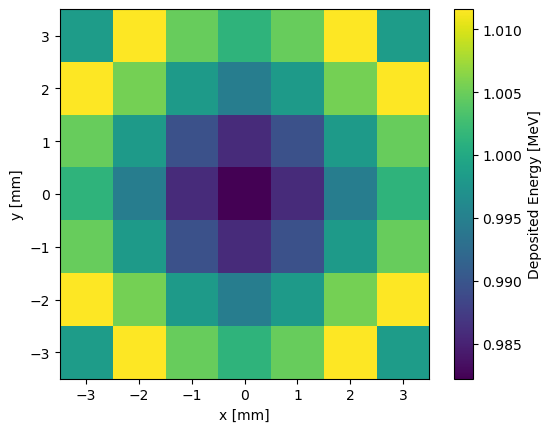

In [10]:
plt.figure(figsize=(6.4, 4.8))
plt.imshow(np.transpose(efficiency_mesh)[::-1,:], extent=(-3.5, 3.5, -3.5, 3.5))
cbar = plt.colorbar()
cbar.ax.set_ylabel("Deposited Energy [MeV]")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")

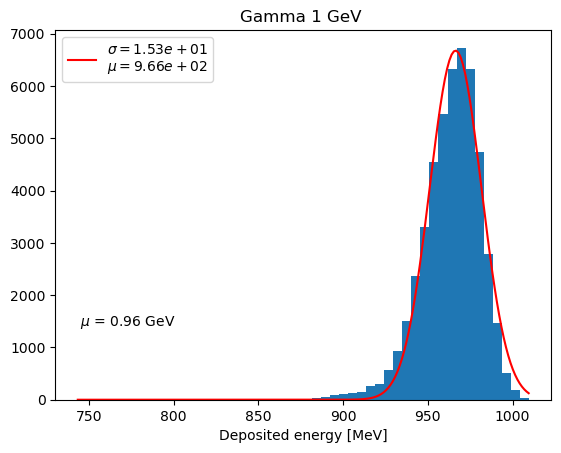

In [11]:
plt.figure()

ax = plt.gca()

dispHistAndGauss(ax, eDep_uniform_source)

ax.text(0.05, 0.2, "$\mu$ = {:.2f} GeV".format(np.mean(eDep_uniform_source)/1000), transform=ax.transAxes)

ax.set_title(f"Gamma 1 GeV ")
ax.set_xlabel("Deposited energy [MeV]")
ax.legend()